# Statoil/C-CORE Iceberg Classifier Challenge
___

### _Ship or iceberg, can you decide from space_?
**Angel Ortiz**

*11th Nov. 2017* 
 
1. Introduction
2. Exploring the Data
3. Visualizing Data
4. Data Formatting
5. Model Selection & Training
6. Submission

## 1-1) Introduction

In this competition the challenge was to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. The remote sensing systems used for detection are housed on the Sentinel-1 satellite which flies above Earth at an altitude of 600km. The satellite captures images using a C-Band radar operating at a frequency that allows for observations during all weather conditions. The satellite radar bounces a signal off an object and records an echo, with higher intensity echoes coming from solid objects of any kind including ships and icebergs. The source of the backscattered signal cannot be directly determined from observing the raw data and the team at Statoil and C-Core must use their analysis tools to classify it into ship or inceberg based on certain characteristics such as shape size and brightness. 

For this contest the data was presented with two channels HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). This can play an important role in the object characteristics, since objects tend to reflect energy differently. The goal is to predict the probability that the image contains an iceberg represented as a 0-1 range float. The labeled training set includes 1604 examples while the test set used for the final submission contains 8424 images.

We begin by importing general purpose Python libraries that will allow us to read and manipulate the testing and training data and begin our exploration of the data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1-3) Loading Test & Train data.

In [7]:
train = pd.read_json('./../../TrainData/data/processed/train.json')
test = pd.read_json('./../../TestData/processed/test.json')

## 2-1) Exploring the data.

In [10]:
# Print the first 5 rows of the training data.
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [9]:
# Print the first 5 rows of the test data.
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [14]:
#Print the shape of the data for both train and test.
print(test.shape, train.shape)

(8424, 4) (1604, 5)


The data is presented as a pandas dataframe consisting of 5 columns. The first column represents the data from the HH band and the second column has the HV band data. The incident angle at which the sample was taken is also included. Lastly an id for each image is found along with a is_iceberg tag for the training set.  Next we want to confirm that the data is given in a flatten list containing all pixel values for the 75,75 image. 

In [24]:
#Print the size of the list containing the image data for both testing and training data.
print(len(test['band_1'][0]), len(test['band_2'][0]))
print(len(train['band_1'][0]), len(train['band_2'][0]))

5625 5625
5625 5625


Next we take a look at the incident angle and fill in the missing values in the training set with the mean value. The data indicates that the inclination angle was mostly in the 40+-4deg range.

In [29]:
test['inc_angle'].describe()

count    8424.000000
mean       40.153403
std         4.108386
min        23.080500
25%        36.905200
50%        40.375790
75%        43.472950
max        50.661785
Name: inc_angle, dtype: float64

In [43]:
train['inc_angle'] = train['inc_angle'].replace('na',np.nan)
train['inc_angle']= train['inc_angle'].fillna(train['inc_angle'].mean())
train['inc_angle'].describe()

count    1604.000000
mean       39.268707
std         3.677005
min        24.754600
25%        36.483175
50%        39.268707
75%        42.512800
max        45.937500
Name: inc_angle, dtype: float64

### 2-2) Exploring correlation between global properties of the images. 
Now we will look at some of the key properties of the features such as minimum and maximum values, the means medians and 50% mid range of the signal values. Since there are two different bands used it will be done for both. The correlation between them is explored in a correlation matrix shown below.

In [44]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

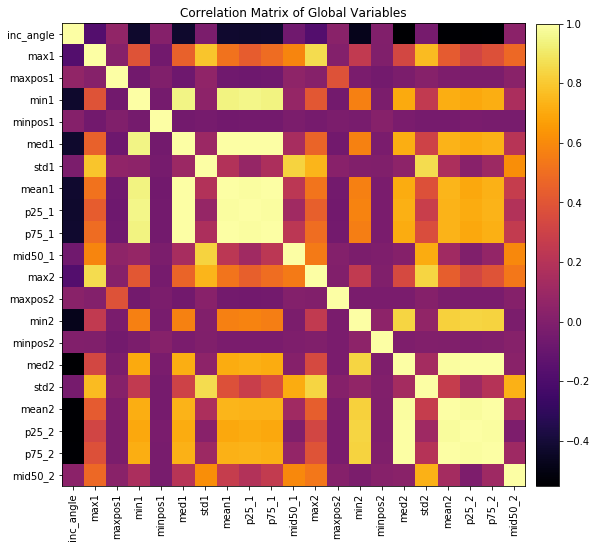

In [45]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

We see that some variables are well correlated. In particular, the mean, median and 25% signal 75% signal are closely related with a value above 70%. The min and max values also show a high degree of correlation indicating that the signal has probnably been scaled down.

## 3-1) Visualizing Data

Before we continue the analysis it is helpful to plot the raw images to better understand the data. Because the images only come with two data bands we will first present each one as a heat map.

In [47]:
# We first separate the training set into icebergs and ships and pick 9 random images from the set.
icebergs = train[train.is_iceberg==1].sample(n=9, random_state=142)
ships = train[train.is_iceberg==0].sample(n=9, random_state = 421)

### 3-2) Plotting raw band_1 image data

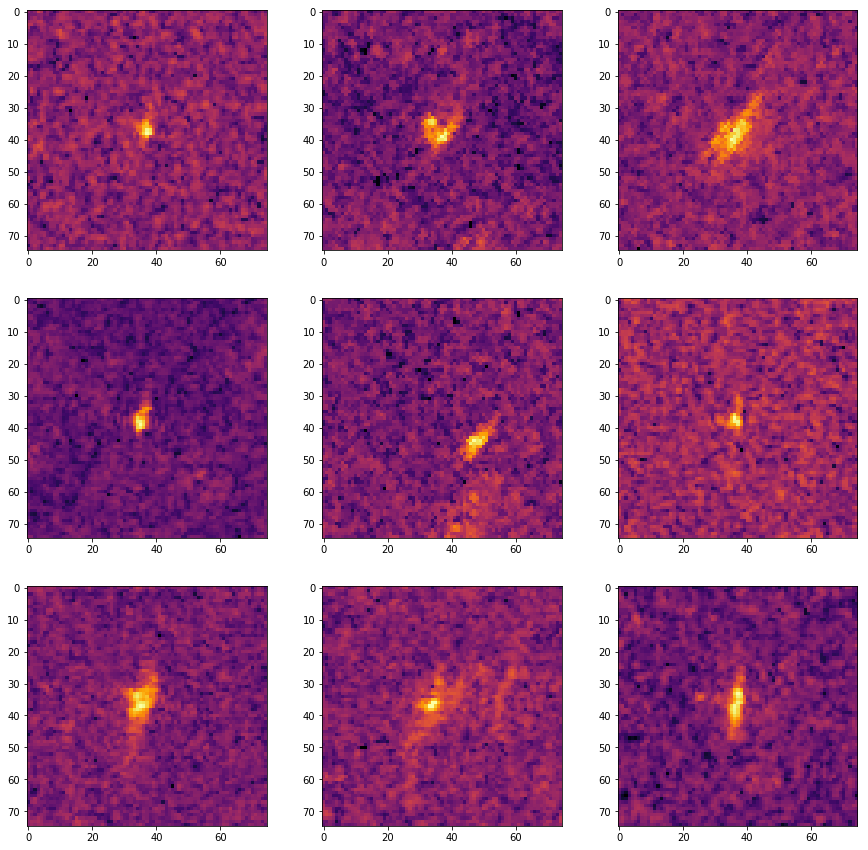

In [49]:
# Plot band_1 data for icebergs
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

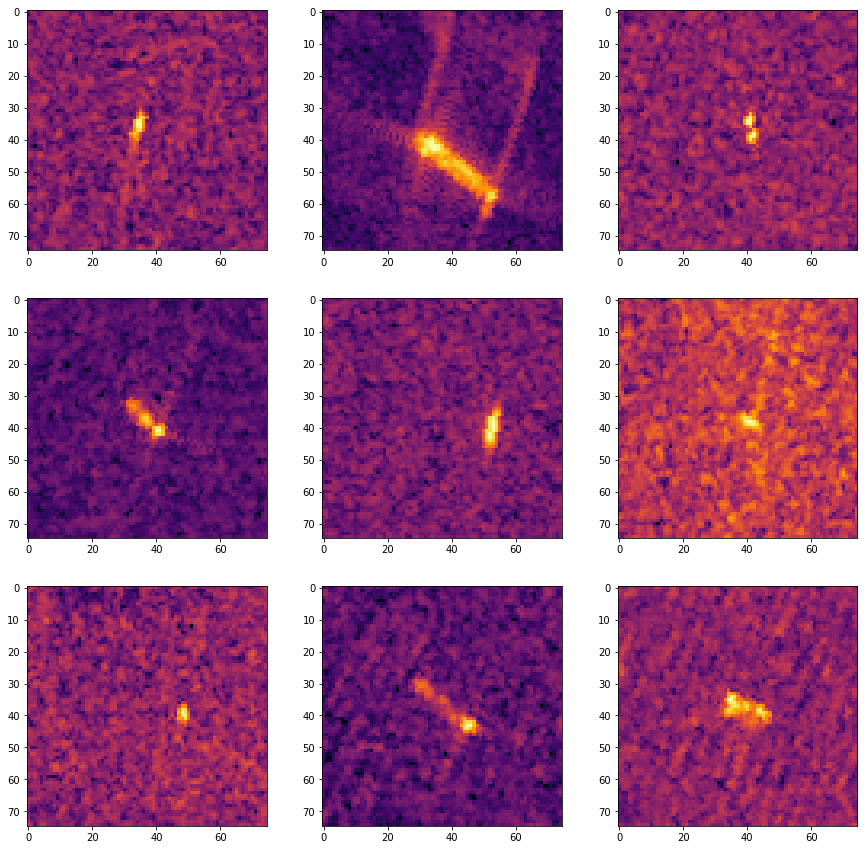

In [50]:
# Plot band_1 data for ships
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

### 3-3) Plotting raw band_2 image data

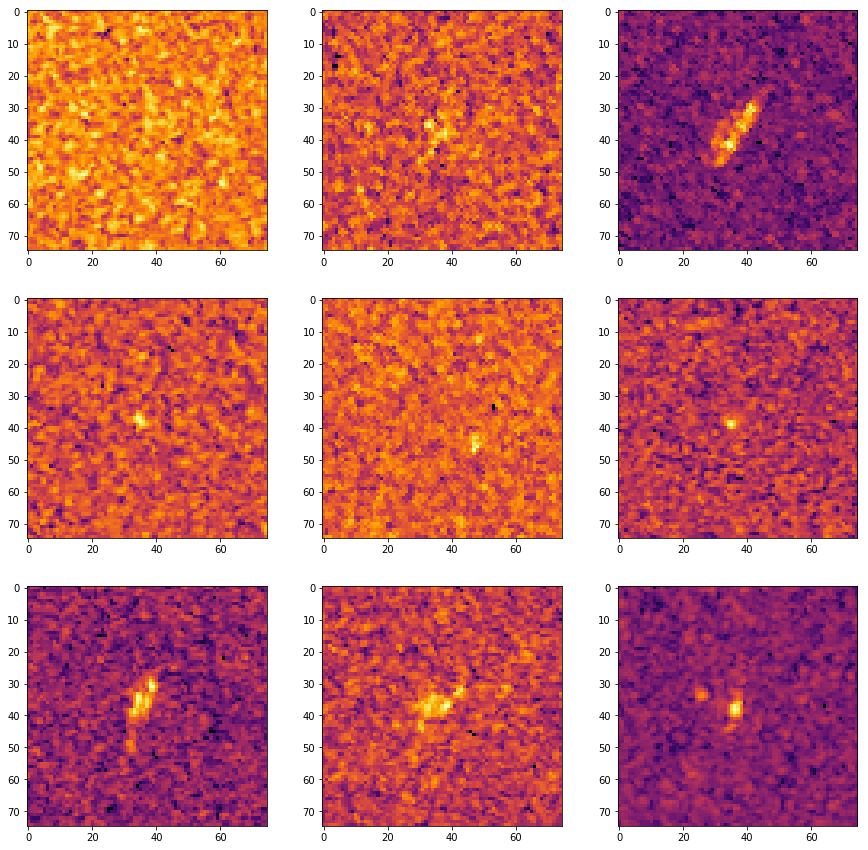

In [51]:
# Plot the same Iceberg subset in band_2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

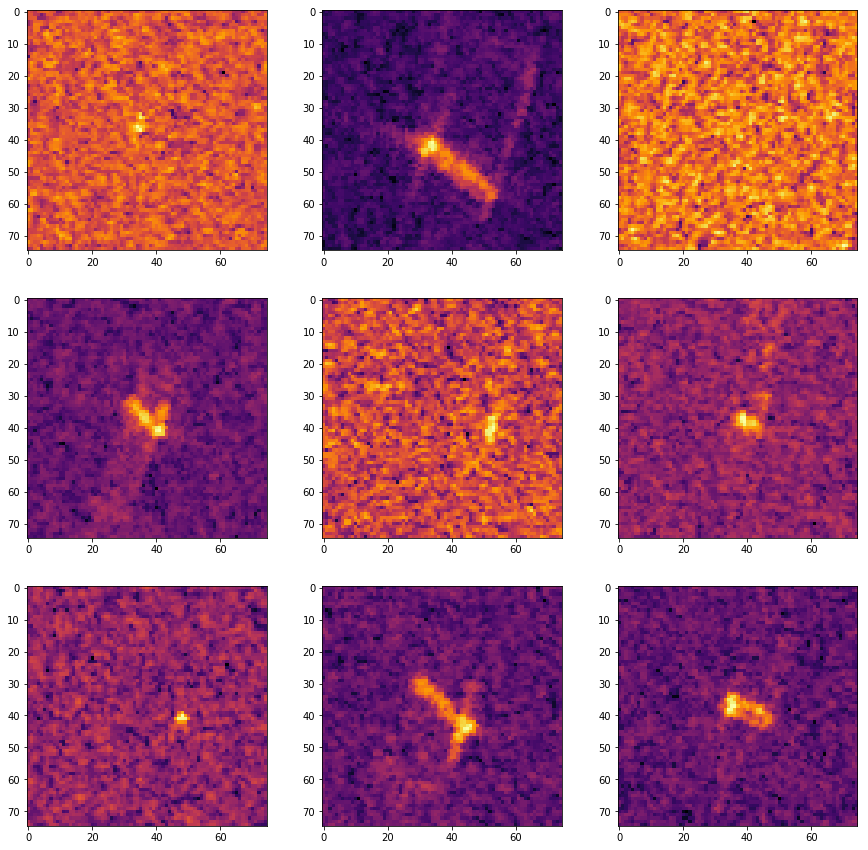

In [52]:
# Plot the same ship subset in band_2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

So, visualizing the data shows how this is not a trivial task at all. For many images the icebergs are practically indistinguishable from the background noise and for others the ships just appear as blob-like objects. The next step shall be to combine the images into rgb values and see if it becomes any easier to visually identify the objects in the images.

### 3-4) Plotting RGB representations of the data.

We construct this artificial RGB image by setting the red channel as the HH band and the green as the HV band while dividing both bands to obtain the blue channel. We then combine them into a single (75,75,3) multidimensional array and use sklearns's fit_transform function to normalize the data into a 0-1 range since it is a requirement for the imshow composition of RGB images. 

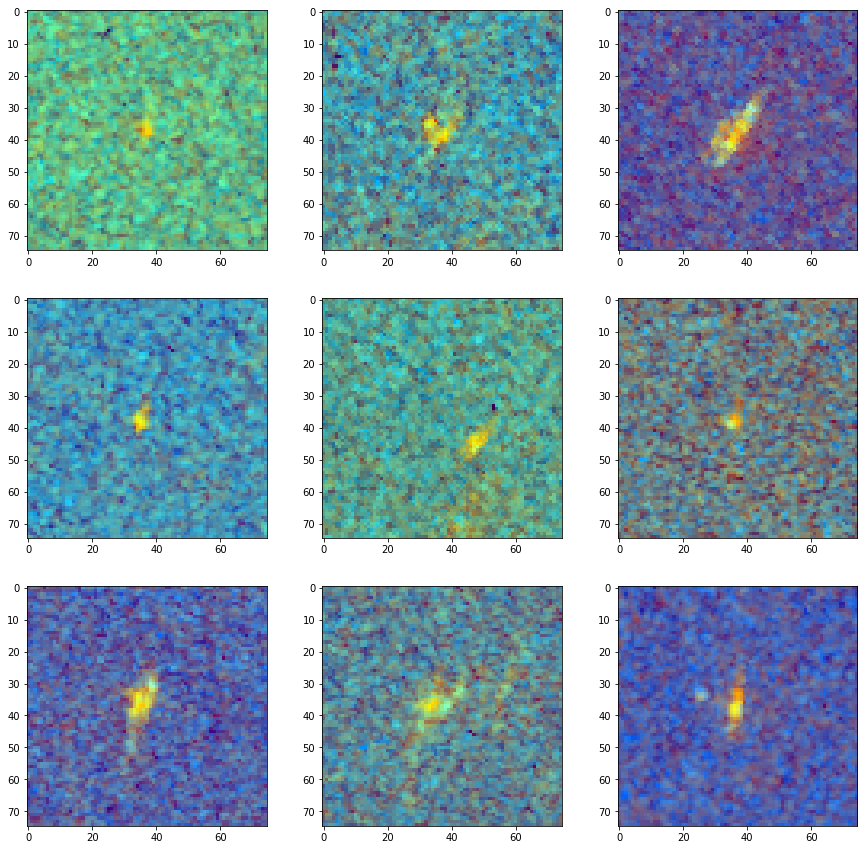

In [59]:
from sklearn import preprocessing
#Iceberg RGB composite
scaler = preprocessing.MinMaxScaler()
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    r = np.array(icebergs.iloc[i,0])
    g = np.array(icebergs.iloc[i,1])
    #b = np.array(icebergs.iloc[i,1])
    b = [r[x]/g[x] for x in range(len(r))]
    rgb = np.array([[r[x],g[x],b[x]]for x in range(len(r))])
    rgb = scaler.fit_transform(rgb)
    rgb = np.reshape(rgb,(75,75,3))
    ax.imshow(rgb)   
plt.show()

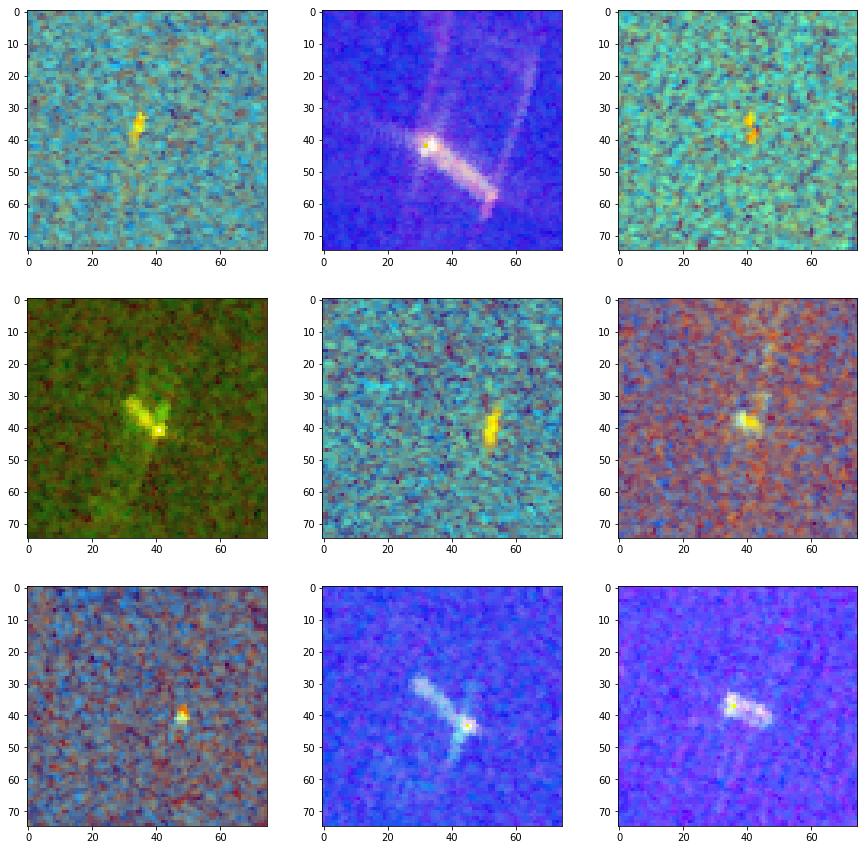

In [60]:
#Ships RGB composites
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    r = np.array(ships.iloc[i,0])
    g = np.array(ships.iloc[i,1])
    b = [r[x]/g[x] for x in range(len(r))]
    rgb = np.array([[r[x],g[x],b[x]]for x in range(len(r))])
    rgb = scaler.fit_transform(rgb)
    rgb = np.reshape(rgb,(75,75,3))
    ax.imshow(rgb)   
plt.show()

The rgb representation highlights much better the location and shapes of the targets in both the ship and iceberg cases. This shall be quite useful when feeding data into our model.

## 4-1) Data Formatting

Before the data can be fed to a training algorithm we must reshape it into a set of 4D tensors (X,75,75,3) and split it into training and validation sets. The testing data shall also be reshaped to allow predictions using the same algorithm.

In [61]:
#Some image format variables
channels = 3
num_classes = 1
#image input dimensions
img_x, img_y = 75,75 

In [ ]:
def reshape_into_rgb(train):
    